# 6章 アルゴリズムチェーンとパイプライン

In [1]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

cancer = load_breast_cancer()
x_train, x_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

scaler = MinMaxScaler().fit(x_train)

x_train_scaled = scaler.transform(x_train)

svm = SVC()
svm.fit(x_train_scaled, y_train)

x_test_scaled = scaler.transform(x_test)
print("Test score: {:.2f}".format(svm.score(x_test_scaled, y_test)))

Test score: 0.95


## 6.1 前処理を行う際のパラメータ選択

In [3]:
from sklearn.model_selection import GridSearchCV

param_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100], "gamma": [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(x_train_scaled, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Best set score: {:.2f}".format(grid.score(x_test_scaled, y_test)))
print("Best parameters: ", grid.best_params_)

Best cross-validation accuracy: 0.98
Best set score: 0.97
Best parameters:  {'C': 1, 'gamma': 1}


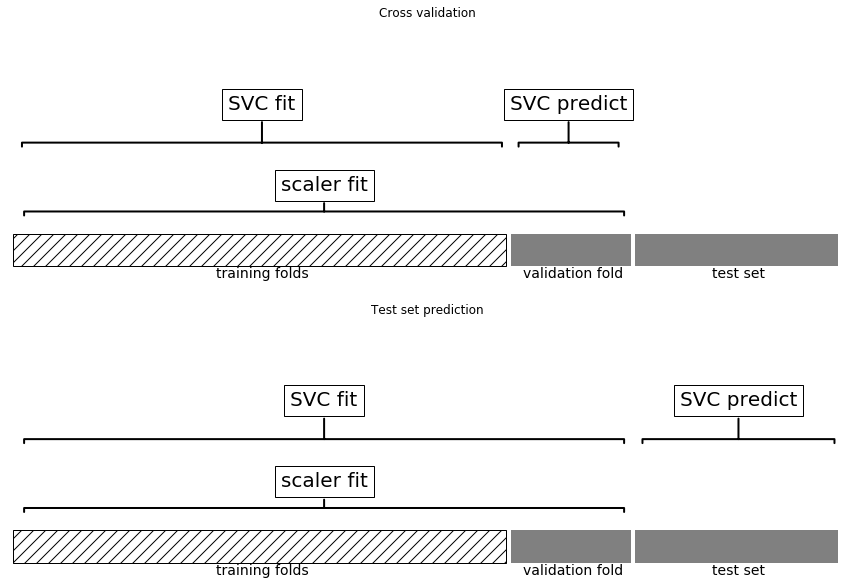

In [6]:
%matplotlib inline
import mglearn
mglearn.plots.plot_improper_processing()